# Southern Ocean EKE  in OCCIPUT

This notebook is our second attempt to make sense of EKE in the Southern Ocean from the OCCIPUT ensemble. In this attemp:
 * EKE has been calculated from daily SSH, using geostrophic velocity (provided by Sally Close).
 * Each component of geostrophic velocity was averaged onto the T grid, squared and resampled monthly.

### Executive Summary

TBD


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import IPython.display
import pandas as pd
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import os 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [3]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [4]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'geouv/'

## Ensemble Averages
First load the EKE from each member, calculate annual climatology and make ensemble average climatology (`eke_month`).

The following cell does this calculation and saves the file for future use. The next cell is for loading precomputed versions.

In [5]:
## To load the EKE climatology
climfilename = HardDisk+EnsembleDir+'eke_climatology.nc'
eke_month = xr.open_dataset(climfilename).EKE

## Calculate intrinsic vs forced variance.
Following Leroux et al. (2016), we define the forced variance of the kinetic energy timeseries of an ensemble member, $E_i(t)$, to be the time-variance of the ensemble-mean timeseries, denoted $\langle E_i(t)\rangle$, :
$$\sigma^2_{\langle E \rangle} = \frac{1}{T} \sum_{t=1}^T \left(\langle E_i \rangle -  \overline{\langle E_i \rangle}\right)^2$$
Note that we can separate each ensemble member into a component due to the ensemble-mean, and its anomaly,
$$E_i = \langle E_i\rangle + E_i'$$
The ensemble-variance (indicating the spread between ensemble members) is then
$$\epsilon^2(t) = \frac{1}{N} \sum_{n=i}^N E_i'(t)^2$$
We can then calculate the ratio of intrinsic to forced variance, as 
$$ R = \frac{A_i}{A_f} = \frac{\sqrt{\overline{\epsilon^2}}}{\sigma_{\langle E \rangle}}$$
If $R$ is large, then intrinsic variability dominates - if $R$ is smaller than 1 then forced varaibility dominates. We calculate these parameters below.

In [44]:
start = pd.datetime(1990,1,1)
nfiles = 50
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    filename = HardDisk+EnsembleDir+Member+'/eke_p_'+i00+'.nc'
    eke_p = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_p = eke_p.rolling(time=12).mean()
    
    filename = HardDisk+EnsembleDir+Member+'/eke_i_'+i00+'.nc'
    eke_i = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_i  = eke_i.rolling(time=12).mean()
    
    filename = HardDisk+EnsembleDir+Member+'/eke_a_'+i00+'.nc'
    eke_a = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_a = eke_a.rolling(time=12).mean()
    
    filename = HardDisk+EnsembleDir+Member+'/eke_s_'+i00+'.nc'
    eke_s = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_s = eke_s.rolling(time=12).mean()
    
    if nn==1:
        eke_tot_sum = eke_s
        eke_pac_sum = eke_p
        eke_ind_sum = eke_i
        eke_atl_sum = eke_a
    else:
        eke_tot_sum = eke_tot_sum + eke_s
        eke_pac_sum = eke_pac_sum + eke_p
        eke_ind_sum = eke_ind_sum + eke_i
        eke_atl_sum = eke_atl_sum + eke_a

eke_tot_sum = eke_tot_sum/nn
eke_pac_sum = eke_pac_sum/nn
eke_ind_sum = eke_ind_sum/nn
eke_atl_sum = eke_atl_sum/nn

sigma2_tot = np.var(eke_tot_sum)
sigma2_pac = np.var(eke_pac_sum)
sigma2_ind = np.var(eke_ind_sum)
sigma2_atl = np.var(eke_atl_sum)

# Now I have ensemble mean, I can calculate ensemble variance.
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    filename = HardDisk+EnsembleDir+Member+'/eke_p_'+i00+'.nc'
    eke_p = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_p = eke_p.rolling(time=12).mean()
    
    filename = HardDisk+EnsembleDir+Member+'/eke_i_'+i00+'.nc'
    eke_i = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_i  = eke_i.rolling(time=12).mean()
    
    filename = HardDisk+EnsembleDir+Member+'/eke_a_'+i00+'.nc'
    eke_a = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_a = eke_a.rolling(time=12).mean()
    
    filename = HardDisk+EnsembleDir+Member+'/eke_s_'+i00+'.nc'
    eke_s = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_s = eke_s.rolling(time=13,center=True).mean()
    
    if nn==1:
        eke_tot_var = (eke_s - eke_tot_sum)**2
        eke_pac_var = (eke_p - eke_pac_sum)**2
        eke_ind_var = (eke_i - eke_ind_sum)**2
        eke_atl_var = (eke_a - eke_atl_sum)**2
    else:
        eke_tot_var = eke_tot_var + (eke_s - eke_tot_sum)**2
        eke_pac_var = eke_pac_var + (eke_p - eke_pac_sum)**2
        eke_ind_var = eke_ind_var + (eke_i - eke_ind_sum)**2
        eke_atl_var = eke_atl_var + (eke_a - eke_atl_sum)**2

eke_tot_var = eke_tot_var/nn
eke_pac_var = eke_pac_var/nn
eke_ind_var = eke_ind_var/nn
eke_atl_var = eke_atl_var/nn

epsilon2_tot = eke_tot_var.mean('time')
epsilon2_pac = eke_pac_var.mean('time')
epsilon2_ind = eke_ind_var.mean('time')
epsilon2_atl = eke_atl_var.mean('time')

ratio_tot = (epsilon2_tot/sigma2_tot)**0.5
ratio_pac = (epsilon2_pac/sigma2_pac)**0.5
ratio_ind = (epsilon2_ind/sigma2_ind)**0.5
ratio_atl = (epsilon2_atl/sigma2_atl)**0.5

print(ratio_tot.values)
print(ratio_pac.values)
print(ratio_ind.values)
print(ratio_atl.values)

1.8338257796859858
1.5606382156331577
1.3727825303091818
2.3554375319356713


## Plotting Ensemble Averages
Plot the ensemble mean, as well as the seasonal (summer/winter) means, and the seasonal differences. For reference, note  the EKE averaging regions used in Hogg et al. (2015), which are:
* Indian Ocean: 40-150°E, 57-44°S (this box spans the longitude split in ORCA025 output)
* Pacific Ocean: 150-288°E, 62-48°S
* Atlantic Ocean: 325-10°E,56-46°S

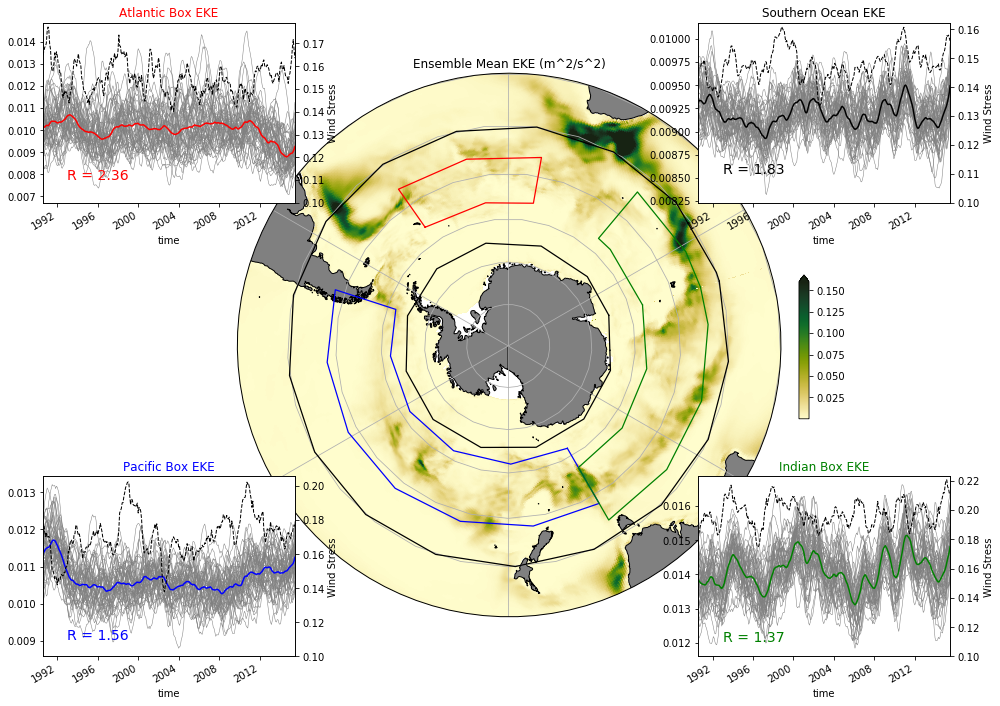

In [48]:
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
p1 = eke_month.mean('month').plot(cmap=cm.cm.speed,vmax=0.16,add_colorbar=False,transform=ccrs.PlateCarree())
plt.plot([-210, -72, -72, -210, -210],[-62,-62,-48, -48, -62],color='b',linewidth=1.25,transform=ccrs.PlateCarree())
plt.plot([-35,10, 10, -35, -35],[-56, -56,-46, -46, -56],color='r',linewidth=1.25,transform=ccrs.PlateCarree())
plt.plot([73, 40, 40, 73],[-57, -57,-44, -44],color='g',linewidth=1.25,transform=ccrs.PlateCarree())
plt.plot([-287, -210, -210, -287],[-57, -57,-44, -44],color='g',linewidth=1.25,transform=ccrs.PlateCarree())
plt.plot([-287, 73],[-65, -65],color='k',linewidth=1.25,transform=ccrs.PlateCarree())
plt.plot([-287, 73],[-40, -40],color='k',linewidth=1.25,transform=ccrs.PlateCarree())
plt.title('Ensemble Mean EKE (m^2/s^2)')

ax_c = plt.axes([0.8,0.4,0.01,0.2])
plt.colorbar(p1,cax=ax_c,orientation='vertical',extend='max')

ax_p = plt.axes([0.05, 0.07, 0.25, 0.25])
ax_i = plt.axes([0.7, 0.07, 0.25, 0.25])
#ax_i.yaxis.tick_right()
ax_a = plt.axes([0.05, 0.7, 0.25, 0.25])
ax_s = plt.axes([0.7, 0.7, 0.25, 0.25])
#ax_s.yaxis.tick_right()

nfiles = 50
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    filename = HardDisk+EnsembleDir+Member+'/eke_p_'+i00+'.nc'
    eke_p = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_p = eke_p.rolling(time=13,center=True).mean()
    eke_p.plot(ax=ax_p,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    filename = HardDisk+EnsembleDir+Member+'/eke_i_'+i00+'.nc'
    eke_i = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_i  = eke_i.rolling(time=13,center=True).mean()
    eke_i.plot(ax=ax_i,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    filename = HardDisk+EnsembleDir+Member+'/eke_a_'+i00+'.nc'
    eke_a = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_a = eke_a.rolling(time=13,center=True).mean()
    eke_a.plot(ax=ax_a,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    filename = HardDisk+EnsembleDir+Member+'/eke_s_'+i00+'.nc'
    eke_s = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
    eke_s = eke_s.rolling(time=13,center=True).mean()
    eke_s.plot(ax=ax_s,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
    if nn==1:
        eke_tot_sum = eke_s
        eke_pac_sum = eke_p
        eke_ind_sum = eke_i
        eke_atl_sum = eke_a
    else:
        eke_tot_sum = eke_tot_sum + eke_s
        eke_pac_sum = eke_pac_sum + eke_p
        eke_ind_sum = eke_ind_sum + eke_i
        eke_atl_sum = eke_atl_sum + eke_a

eke_tot_sum = eke_tot_sum/nn
eke_tot_sum.plot(ax=ax_s,color='k',linewidth=1.5)
ax_st = ax_s.twinx()
taufilename = HardDisk+EnsembleDir+'tau/'+'tau_s.nc'
tau_s = xr.open_mfdataset(taufilename).tau.sel(time=slice(start,None))
tau_s = tau_s.rolling(time=13,center=True).mean()
tau_s.plot(ax=ax_st,color='k',linewidth=1,linestyle='--')
ax_st.set_ylim(ymin=0.1)
ax_st.set_ylabel('Wind Stress')
ax_st.text(pd.datetime(1993,1,1),0.11,'R = %0.2f'%ratio_tot.values,color='k',size=14)
ax_s.set_title('Southern Ocean EKE')
ax_s.autoscale(enable=True, axis='x', tight=True)

eke_pac_sum = eke_pac_sum/nn
eke_pac_sum.plot(ax=ax_p,color='b',linewidth=1.5)
ax_pt = ax_p.twinx()
taufilename = HardDisk+EnsembleDir+'tau/'+'tau_p.nc'
tau_p = xr.open_mfdataset(taufilename).tau.sel(time=slice(start,None))
tau_p.rolling(time=13,center=True).mean().plot(ax=ax_pt,color='k',linewidth=1,linestyle='--')
ax_pt.set_ylim(ymin=0.1)
ax_pt.set_ylabel('Wind Stress')
ax_pt.text(pd.datetime(1993,1,1),0.11,'R = %0.2f'%ratio_pac.values,color='b',size=14)
ax_p.set_title('Pacific Box EKE',color='b')
ax_p.autoscale(enable=True, axis='x', tight=True)

eke_ind_sum = eke_ind_sum/nn
eke_ind_sum.plot(ax=ax_i,color='g',linewidth=1.5)
ax_it = ax_i.twinx()
taufilename = HardDisk+EnsembleDir+'tau/'+'tau_i.nc'
tau_i = xr.open_mfdataset(taufilename).tau.sel(time=slice(start,None))
tau_i.rolling(time=13,center=True).mean().plot(ax=ax_it,color='k',linewidth=1,linestyle='--')
ax_it.set_ylim(ymin=0.1)
ax_it.set_ylabel('Wind Stress')
ax_it.text(pd.datetime(1993,1,1),0.11,'R = %0.2f'%ratio_ind.values,color='g',size=14)
ax_i.set_title('Indian Box EKE',color='g')
ax_i.autoscale(enable=True, axis='x', tight=True)

eke_atl_sum = eke_atl_sum/nn
eke_atl_sum.plot(ax=ax_a,color='r',linewidth=1.5)
ax_at = ax_a.twinx()
taufilename = HardDisk+EnsembleDir+'tau/'+'tau_a.nc'
tau_a = xr.open_mfdataset(taufilename).tau.sel(time=slice(start,None))
tau_a.rolling(time=13,center=True).mean().plot(ax=ax_at,color='k',linewidth=1,linestyle='--')
ax_at.set_ylim(ymin=0.1)
ax_at.set_ylabel('Wind Stress')
ax_at.text(pd.datetime(1993,1,1),0.11,'R = %0.2f'%ratio_atl.values,color='r',size=14)
ax_a.set_title('Atlantic Box EKE',color='r')
ax_a.autoscale(enable=True, axis='x', tight=True)

plt.savefig('EKE_Hogg2015.png')

**This Figure Shows** the EKE timeseries of individual ensemble members in grey and the ensemble mean in blue for the entire SO, and for the 3 individual sectors. There is the expected interannual  peak from 2001-03 (consistent with a SAM  peak in 1998-99 and a 2-3 year lag; see Meredith & Hogg, 2006); but we only see this in the Pacific and (to a lesser extent) the Indian sector. There is also a trend in the Pacific and perhaps the Indian. The Indian sector has some interannual  variability which may have a relationship with the SAM (shown in the red line). 

The ensemble runs shown here are  much cleaner than previous analyses we have done, leading to the possibility of using smaller averaging regions to tease out the different dynamics at play. In the following, we break EKE down into a few randomly chosen regions, to highlight how we may be able to use these diagnostics. 

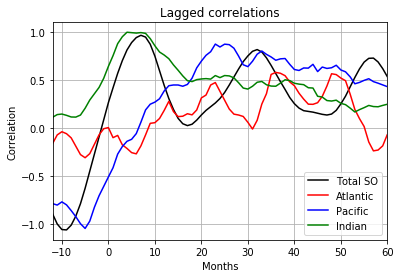

In [49]:
# Is there a lagged correlation?
ekep = eke_tot_sum[6:-6] - eke_tot_sum.mean()
taup = tau_s[6:-6] - tau_s.mean()
coef = np.correlate(ekep,taup,mode='full')
lag = coef.argmax() - ekep.shape[0] + 1

nn = ekep.shape[0]
plt.plot(np.arange(-nn+1,nn),coef/coef.max(),color='k',label='Total SO')


ekep = eke_atl_sum[6:-6] - eke_atl_sum.mean()
taup = tau_a[6:-6] - tau_a.mean()
coef = np.correlate(ekep,taup,mode='full')
lag = coef.argmax() - ekep.shape[0] + 1
plt.plot(np.arange(-nn+1,nn),coef/coef.max(),color='r',label="Atlantic")


ekep = eke_pac_sum[6:-6] - eke_pac_sum.mean()
taup = tau_p[6:-6] - tau_p.mean()
coef = np.correlate(ekep,taup,mode='full')
lag = coef.argmax() - ekep.shape[0] + 1
plt.plot(np.arange(-nn+1,nn),coef/coef.max(),color='b',label="Pacific")

ekep = eke_ind_sum[6:-6] - eke_ind_sum.mean()
taup = tau_p[6:-6] - tau_p.mean()
coef = np.correlate(ekep,taup,mode='full')
lag = coef.argmax() - ekep.shape[0] + 1
plt.plot(np.arange(-nn+1,nn),coef/coef.max(),color='g',label="Indian")

plt.legend()
plt.xlim([-12,60])
plt.title('Lagged correlations')
plt.xlabel('Months')
plt.ylabel('Correlation')
plt.grid()

In [56]:
# function to add stuff to full plot
def add_box(ax, ax_p, col, desc, lon1, lon2, lat1, lat2,long_name):
    ax.plot([lon1, lon2, lon2, lon1, lon1],[lat1,lat1,lat2,lat2,lat1],
            color=col,linewidth=1.25,transform=ccrs.PlateCarree())
    
    start = pd.datetime(1980,1,1) ## start time for plotting
    nfiles = 50
    nn=0
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        filename = HardDisk+EnsembleDir+Member+'/eke_'+desc+'_'+i00+'.nc'
        eke = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
        eke = eke.rolling(time=13,center=True).mean()
        eke.plot(ax=ax_p,color=[0.5, 0.5, 0.5],linewidth=0.5)
    
        if nn==1:
            eke_sum = eke
        else:
            eke_sum = eke_sum + eke
            
    eke_sum = eke_sum/nn
    eke_sum.plot(ax=ax_p,color=col,linewidth=1.5)
    sigma2 = np.var(eke_sum)


    # Now I have ensemble mean, I can calculate ensemble variance.
    nn=0
    for ii in range(1,nfiles+1):
        nn+=1
        i00 = '%03d' % ii
        Member = 'e'+i00
        filename = HardDisk+EnsembleDir+Member+'/eke_'+desc+'_'+i00+'.nc'
        eke = xr.open_dataset(filename).EKE.sel(time=slice(start,None))
        eke = eke.rolling(time=13,center=True).mean()
    
        if nn==1:
            eke_var = (eke - eke_sum)**2
        else:
            eke_var = eke_var + (eke - eke_sum)**2

    eke_var = eke_var/nn

    epsilon2 = eke_var.mean('time')

    ratio = (epsilon2/sigma2)**0.5
    
    ax_pt = ax_p.twinx()
    taufilename = HardDisk+EnsembleDir+'tau/'+'tau_'+desc+'.nc'
    tau = xr.open_mfdataset(taufilename).tau.sel(time=slice(start,None))
    tau = tau.rolling(time=13,center=True).mean()
    tau.plot(ax=ax_pt,color='k',linewidth=1,linestyle='--')
    ax_pt.set_ylim(ymin=0.08)
    ax_pt.set_ylabel('Wind Stress')
    
    # Is there a lagged correlation?
    ekep = eke_sum[6:-6] - eke_sum.mean()
    taup = tau[6:-6] - tau.mean()
    coef = np.correlate(ekep,taup,mode='full')
    lag = coef.argmax() - ekep.shape[0] + 1
    
    ax_pt.text(pd.datetime(1983,1,1),0.082,'R = %0.1f - lag = %d months'%(ratio.values,lag),color=col,size=14)
    
    ax_p.set_title(long_name +' EKE',color=col)
    ax_p.autoscale(enable=True, axis='x', tight=True)

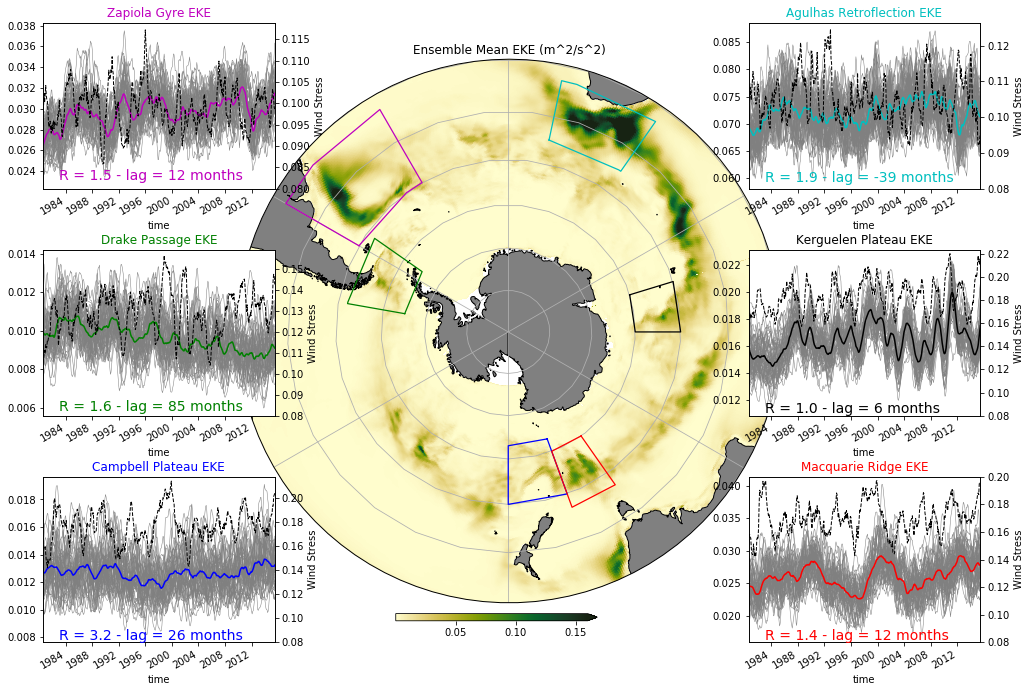

In [57]:
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
p1 = eke_month.mean('month').plot(cmap=cm.cm.speed,vmax=0.16,add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title('Ensemble Mean EKE (m^2/s^2)')
ax_c = plt.axes([0.4,0.1,0.2,0.01])
plt.colorbar(p1,cax=ax_c,orientation='horizontal',extend='max')

# First batch of 6:

# Campbell Plateau
ax_cp = plt.axes([0.05, 0.07, 0.23, 0.23])
add_box(ax,ax_cp,'b', 'cp', -200, -180, -63, -50,'Campbell Plateau')

# Drake Passage
ax_dp = plt.axes([0.05, 0.385, 0.23, 0.23])
add_box(ax,ax_dp,'g', 'dp', -80, -55, -65, -52,'Drake Passage')

# Malvinas/Zapiola
ax_mv = plt.axes([0.05, 0.7, 0.23, 0.23])
add_box(ax,ax_mv,'m', 'mv', -60, -30, -50, -33,'Zapiola Gyre')

# Agulhas
ax_ag = plt.axes([0.75, 0.7, 0.23, 0.23])
add_box(ax,ax_ag,'c', 'ag', 12,  35, -45,  -33,'Agulhas Retroflection')

# Kerguelen Plateau
ax_ke = plt.axes([0.75, 0.385, 0.23, 0.23])
add_box(ax,ax_ke,'k', 'ke', -287, -270, -60, -50,'Kerguelen Plateau')

# Macquarie Ridge
ax_mr = plt.axes([0.75, 0.07, 0.23, 0.23])
add_box(ax,ax_mr,'r', 'mr', -215, -200, -60, -47,'Macquarie Ridge')

plt.savefig('SouthernOceanEKE.png',dpi=250)

## Another box

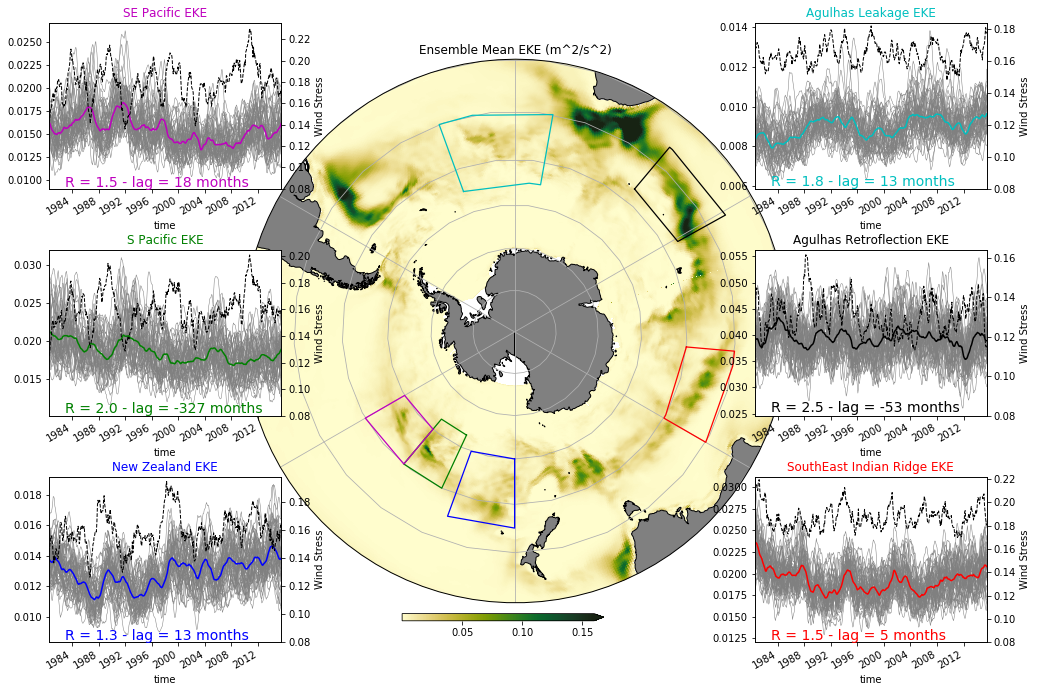

In [59]:
plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-287, 73, -80, -30], crs=ccrs.PlateCarree())

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.add_feature(land_50m)
ax.gridlines()
p1 = eke_month.mean('month').plot(cmap=cm.cm.speed,vmax=0.16,add_colorbar=False,transform=ccrs.PlateCarree())
ax.set_title('Ensemble Mean EKE (m^2/s^2)')
ax_c = plt.axes([0.4,0.1,0.2,0.01])
plt.colorbar(p1,cax=ax_c,orientation='horizontal',extend='max')

# First batch of 6:

# NZ
ax_nz = plt.axes([0.05, 0.07, 0.23, 0.23])
add_box(ax, ax_nz, 'b', 'nz', -180, -160, -60, -45, 'New Zealand')


# South PacificDrake Passage
ax_p1 = plt.axes([0.05, 0.385, 0.23, 0.23])
add_box(ax, ax_p1, 'g', 'p1', -155, -140, -63, -50, 'S Pacific')

# SE Pacific
ax_p2 = plt.axes([0.05, 0.7, 0.23, 0.23])
add_box(ax, ax_p2, 'm', 'p2', -140, -120, -60, -50, 'SE Pacific')

# Agulhas Leakage
ax_al = plt.axes([0.75, 0.7, 0.23, 0.23])
add_box(ax, ax_al, 'c', 'al', -20,  10, -55,  -40, 'Agulhas Leakage')

# Agulhas Retroflection
ax_ar = plt.axes([0.75, 0.385, 0.23, 0.23])
add_box(ax, ax_ar, 'k', 'ar', 40,  61, -47,  -36, 'Agulhas Retroflection')

# SEIR
ax_se = plt.axes([0.75, 0.07, 0.23, 0.23])
add_box(ax, ax_se, 'r', 'se', -265, -240, -50, -40, 'SouthEast Indian Ridge')

plt.savefig('SouthernOceanEKE2.png',dpi=250)

## To Do Next:
* Bin behaviour into "depth" bins, or topographic gradient bins?

